<a href="https://colab.research.google.com/github/ntkl06/khanhlinh06.github.io/blob/main/Lab02_phan_loai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# THỰC HÀNH: CÁC GIẢI THUẬT PHÂN LOẠI CƠ BẢN


## A. MỤC TIÊU CHƯƠNG
- Hiểu và triển khai các giải thuật phân loại: **Cây quyết định & Rừng cây (Decision Tree & Random Forest)**, **SVM**, **Naive Bayes** bằng Python (Scikit‑learn,…).
- Nắm quy trình tiền xử lý dữ liệu, đánh giá mô hình (accuracy, precision, recall, F1, ROC AUC), và tối ưu siêu tham số (cross‑validation, grid search).
- Diễn giải kết quả, phát hiện overfitting và đề xuất cải tiến.



## B. KẾT CẤU THỰC HÀNH
1) Giải thuật **Cây quyết định & Rừng cây**  
2) Giải thuật **Support Vector Machine (SVM)**  
3) Giải thuật **Naive Bayes**



---
### 2.1. GIẢI THUẬT 1: CÂY QUYẾT ĐỊNH & RỪNG CÂY

#### 2.1.1. Ôn tập lý thuyết
- CRISP‑DM và SEMMA là gì? Các giai đoạn chính?  
- Cấu trúc cây quyết định (nút gốc, nút lá, nhánh) và cách dự đoán.  
- Tiêu chí tách: **Gini**, **Entropy/Information Gain** – khác nhau thế nào?  
- **Random Forest** khác cây đơn ra sao? Khi nào rừng tốt hơn?  
- Cách đánh giá **feature importance**; cách chống overfitting.  
- GridSearchCV/RandomizedSearchCV điều chỉnh siêu tham số.


#### 2.1.2. Bài làm mẫu (GIỮ NGUYÊN CODE MẪU Lab02)

###### Bài toán 1: Xây dựng cây quyết định và rừng cây với dữ liệu


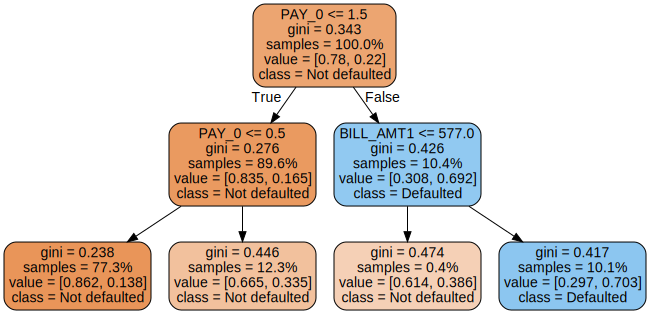

In [ ]:
# === Code mẫu GIỮ NGUYÊN từ Lab02 ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400
import graphviz
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

# 1) Nạp dữ liệu & loại cột không dùng (ví dụ như trong Lab02)
df = pd.read_csv('data_Lab2/credit.csv')
features_response = df.columns.tolist()
items_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'EDUCATION_CAT', 'graduate school', 'high school', 'none',
                   'others', 'university']
features_response = [c for c in features_response if c not in items_to_remove]

# 2) Chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(
    df[features_response[:-1]].values,
    df['default payment next month'].values,
    test_size=0.2, random_state=24)

# 3) Cây quyết định
dt = tree.DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

dot_data = tree.export_graphviz(
    dt, out_file=None, filled=True, rounded=True,
    feature_names=features_response[:-1], proportion=True,
    class_names=['Not defaulted', 'Defaulted'])
graph = graphviz.Source(dot_data)
graph

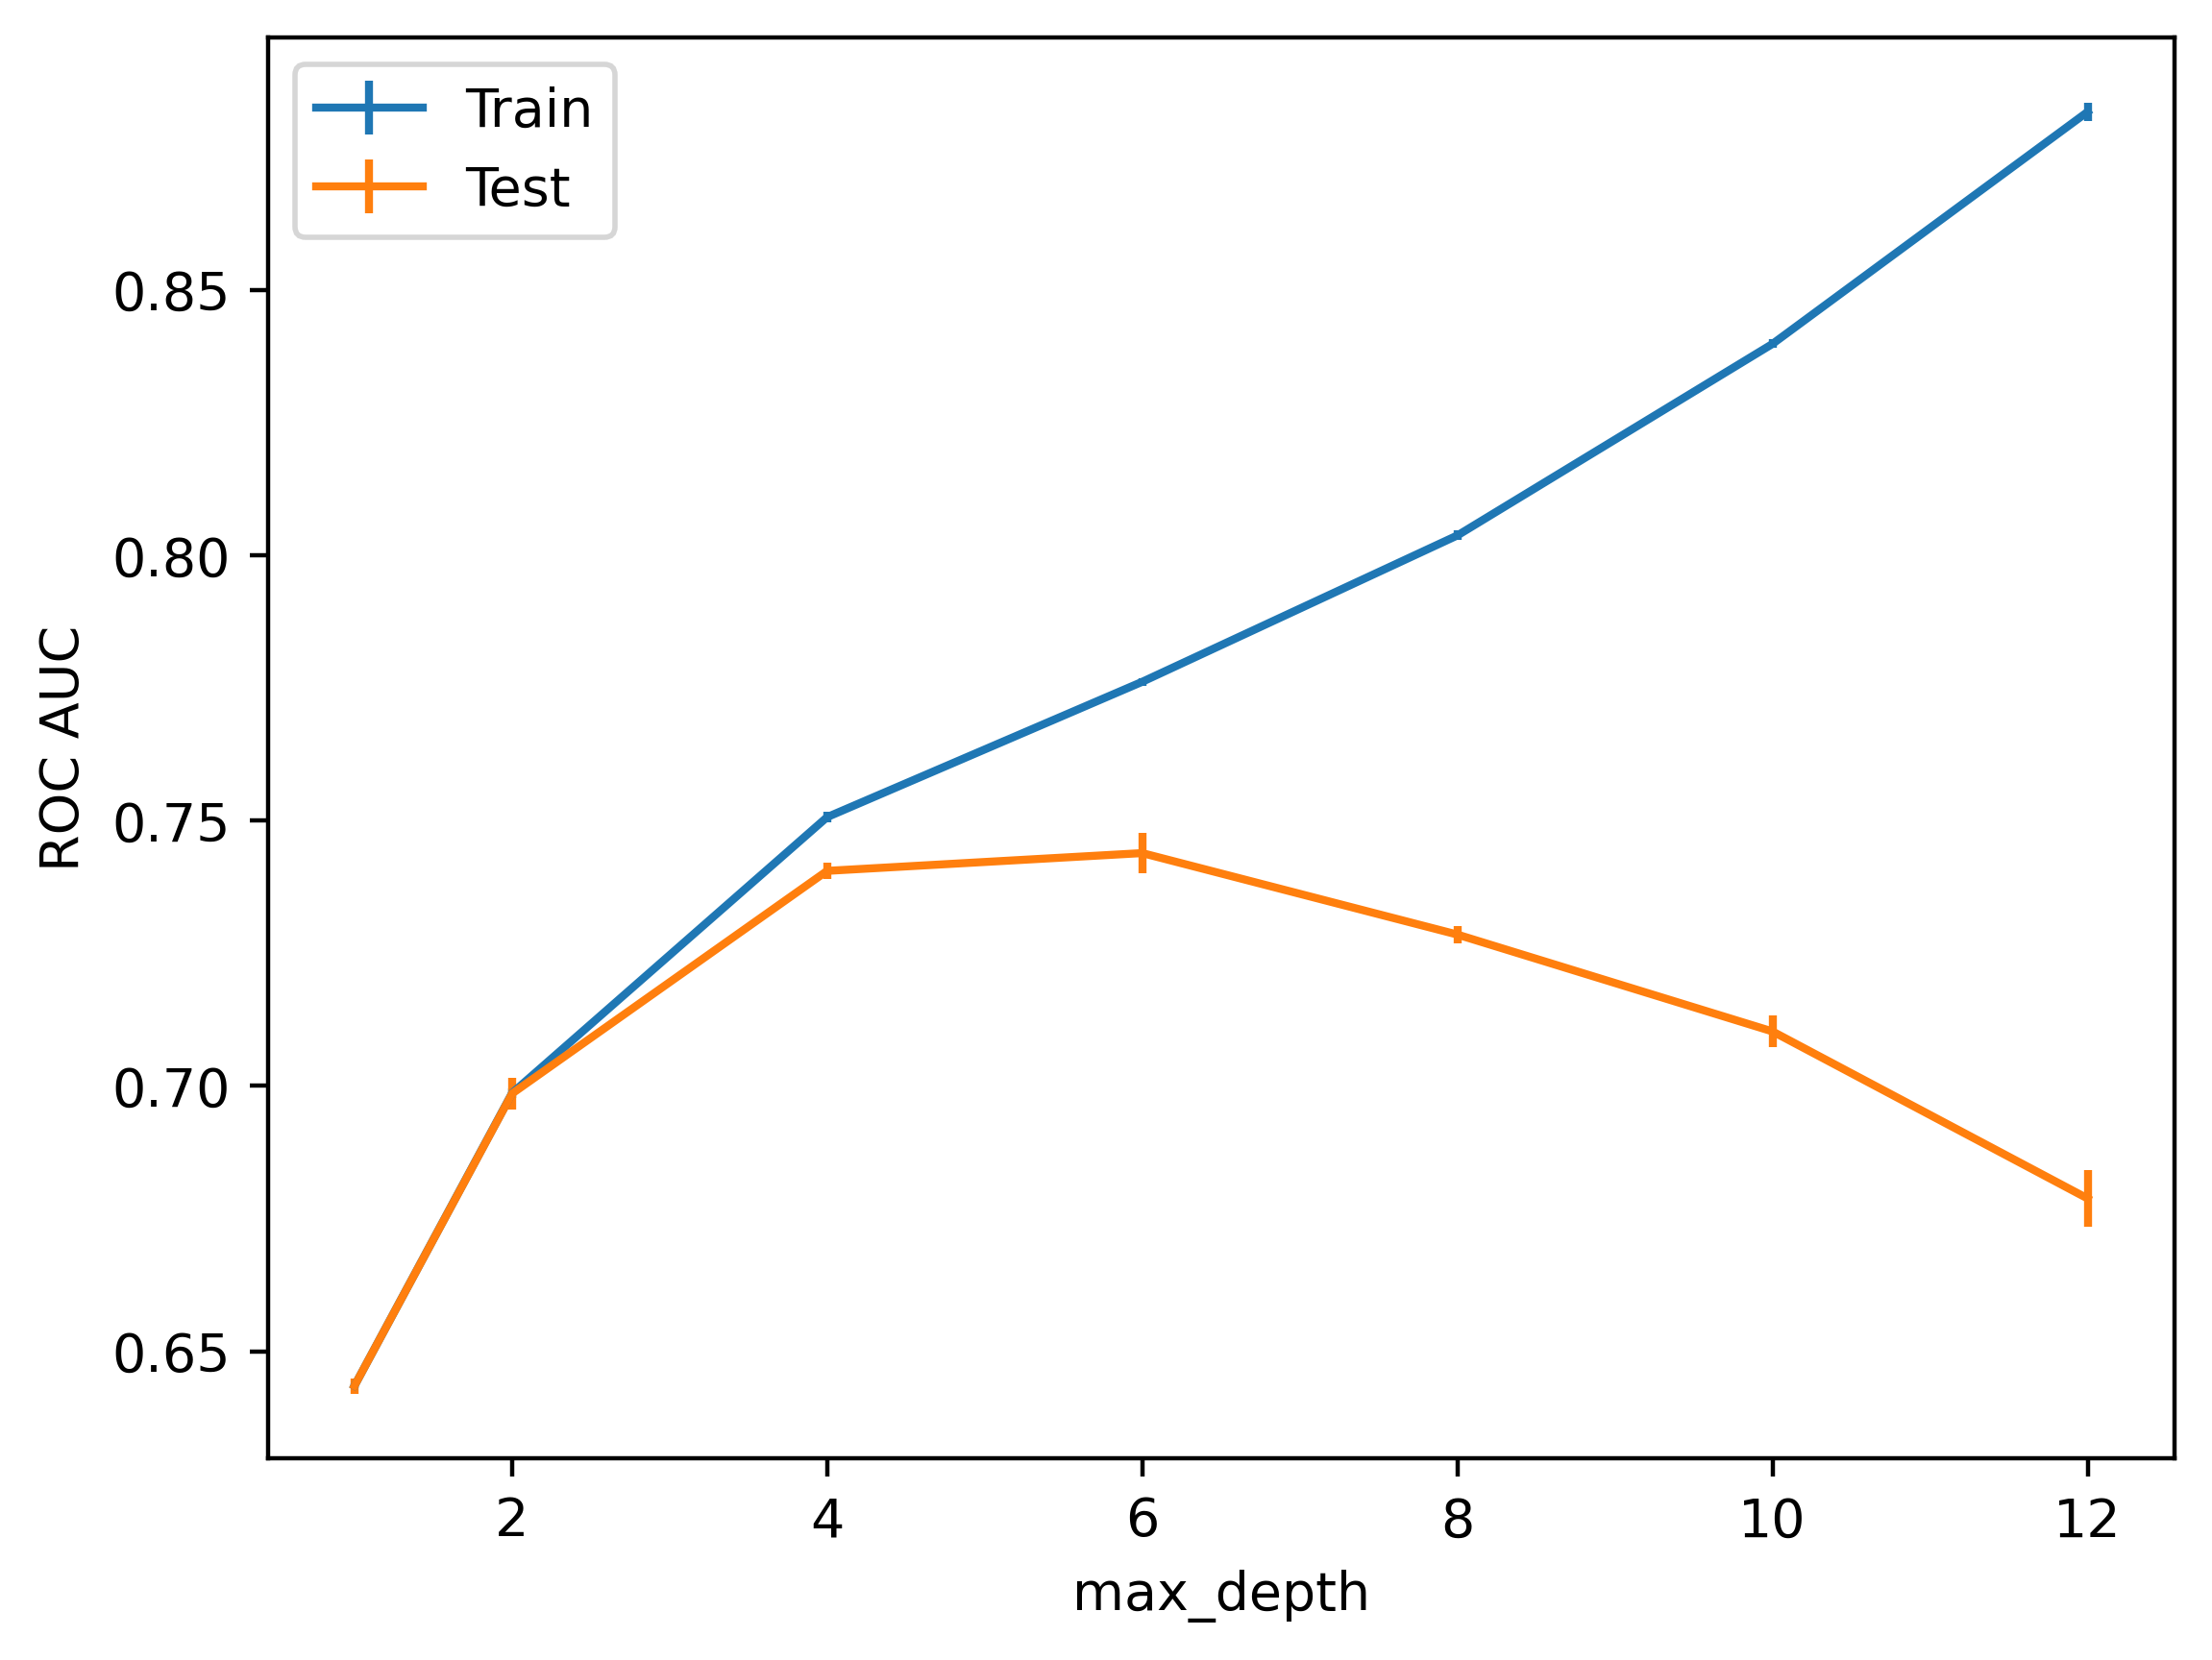

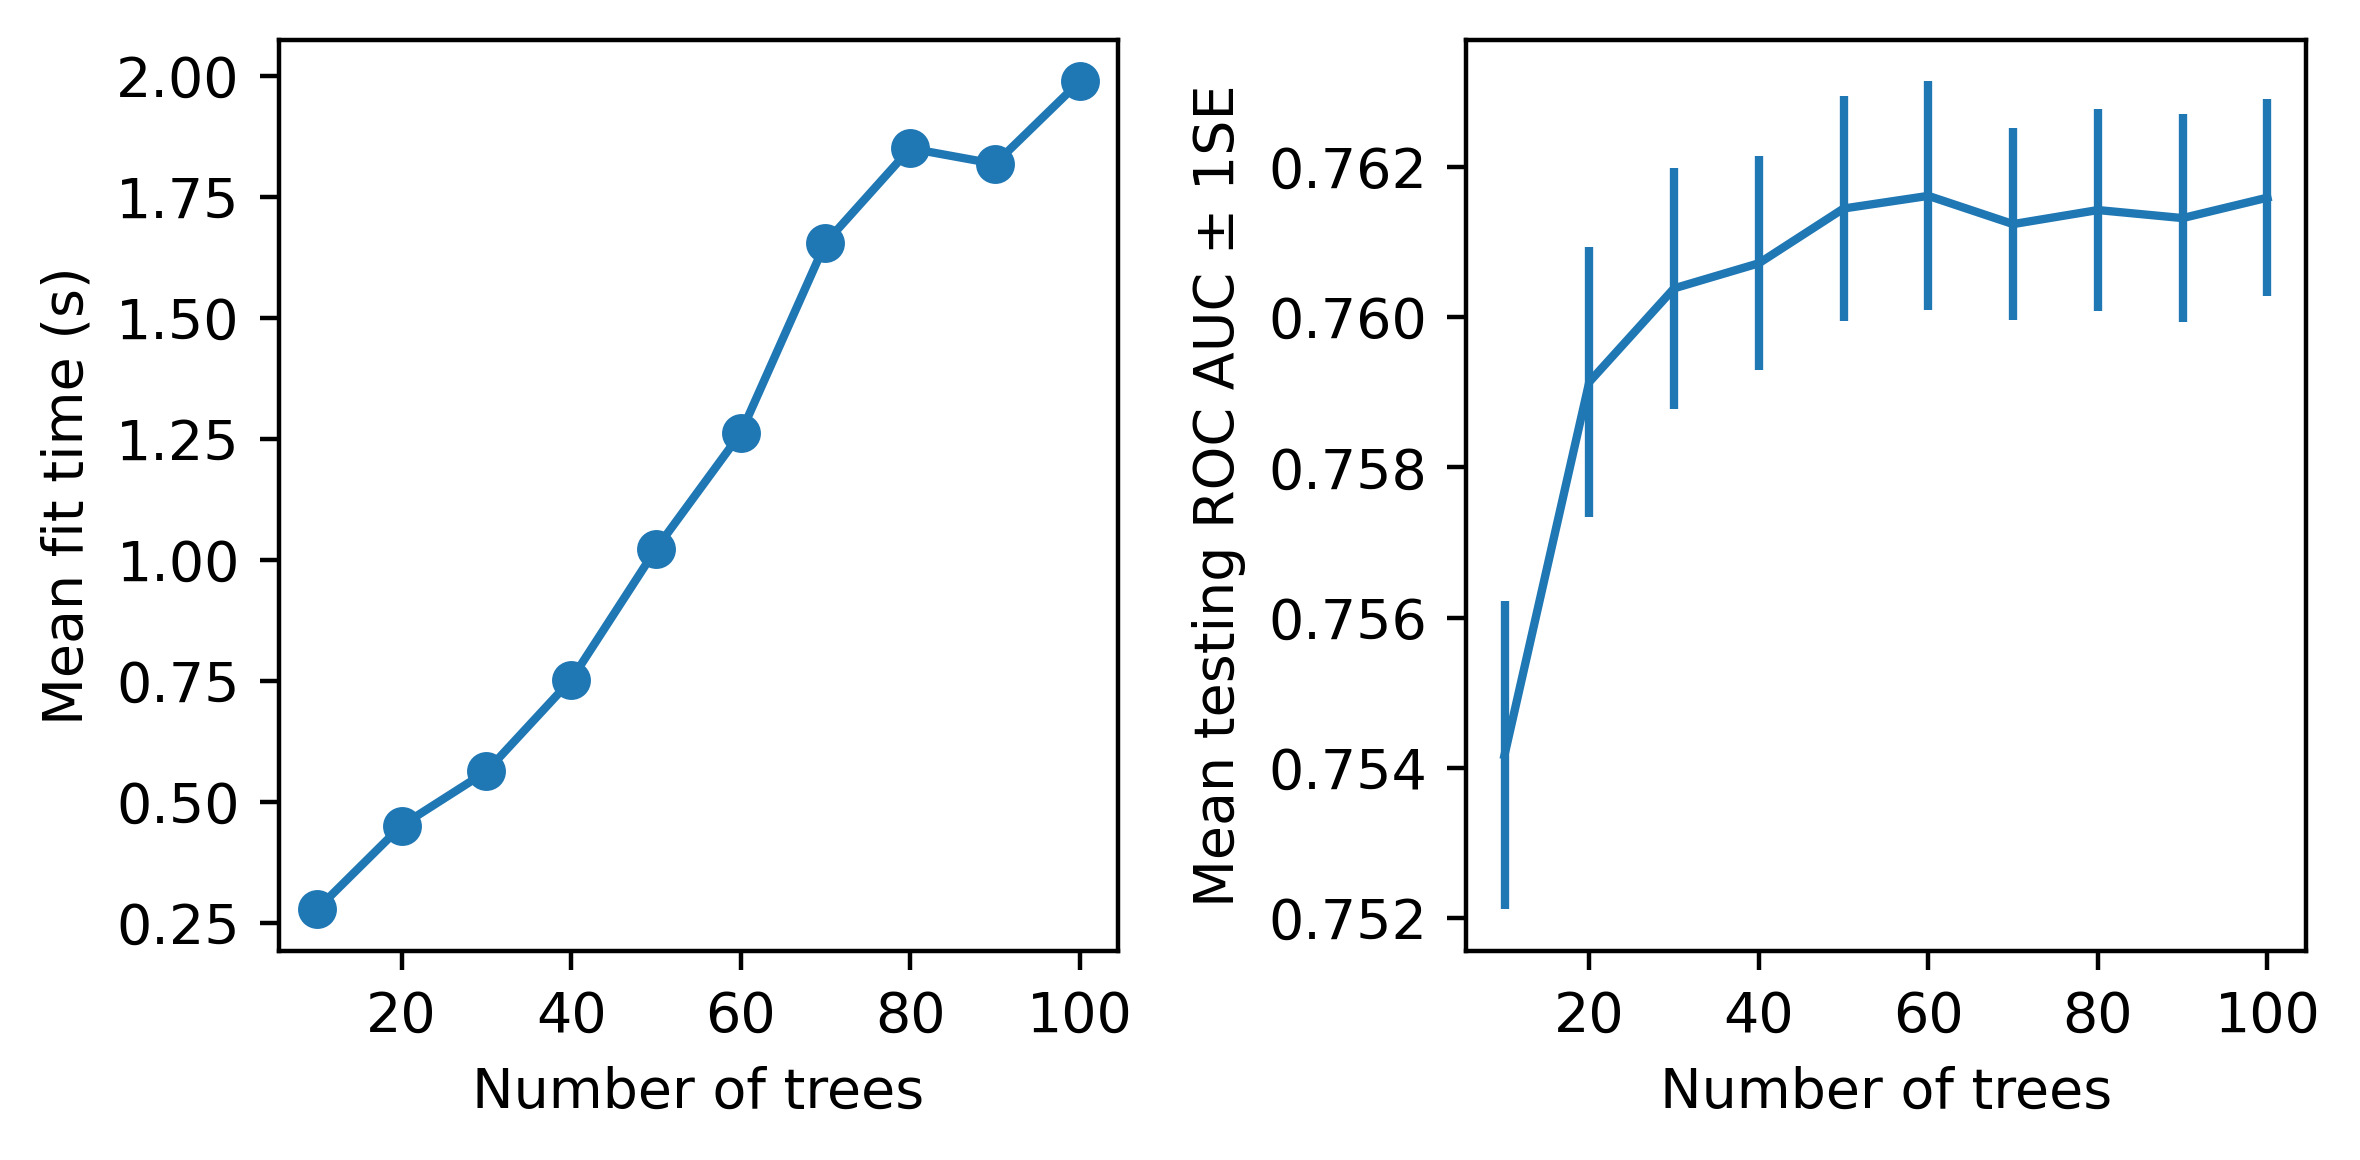

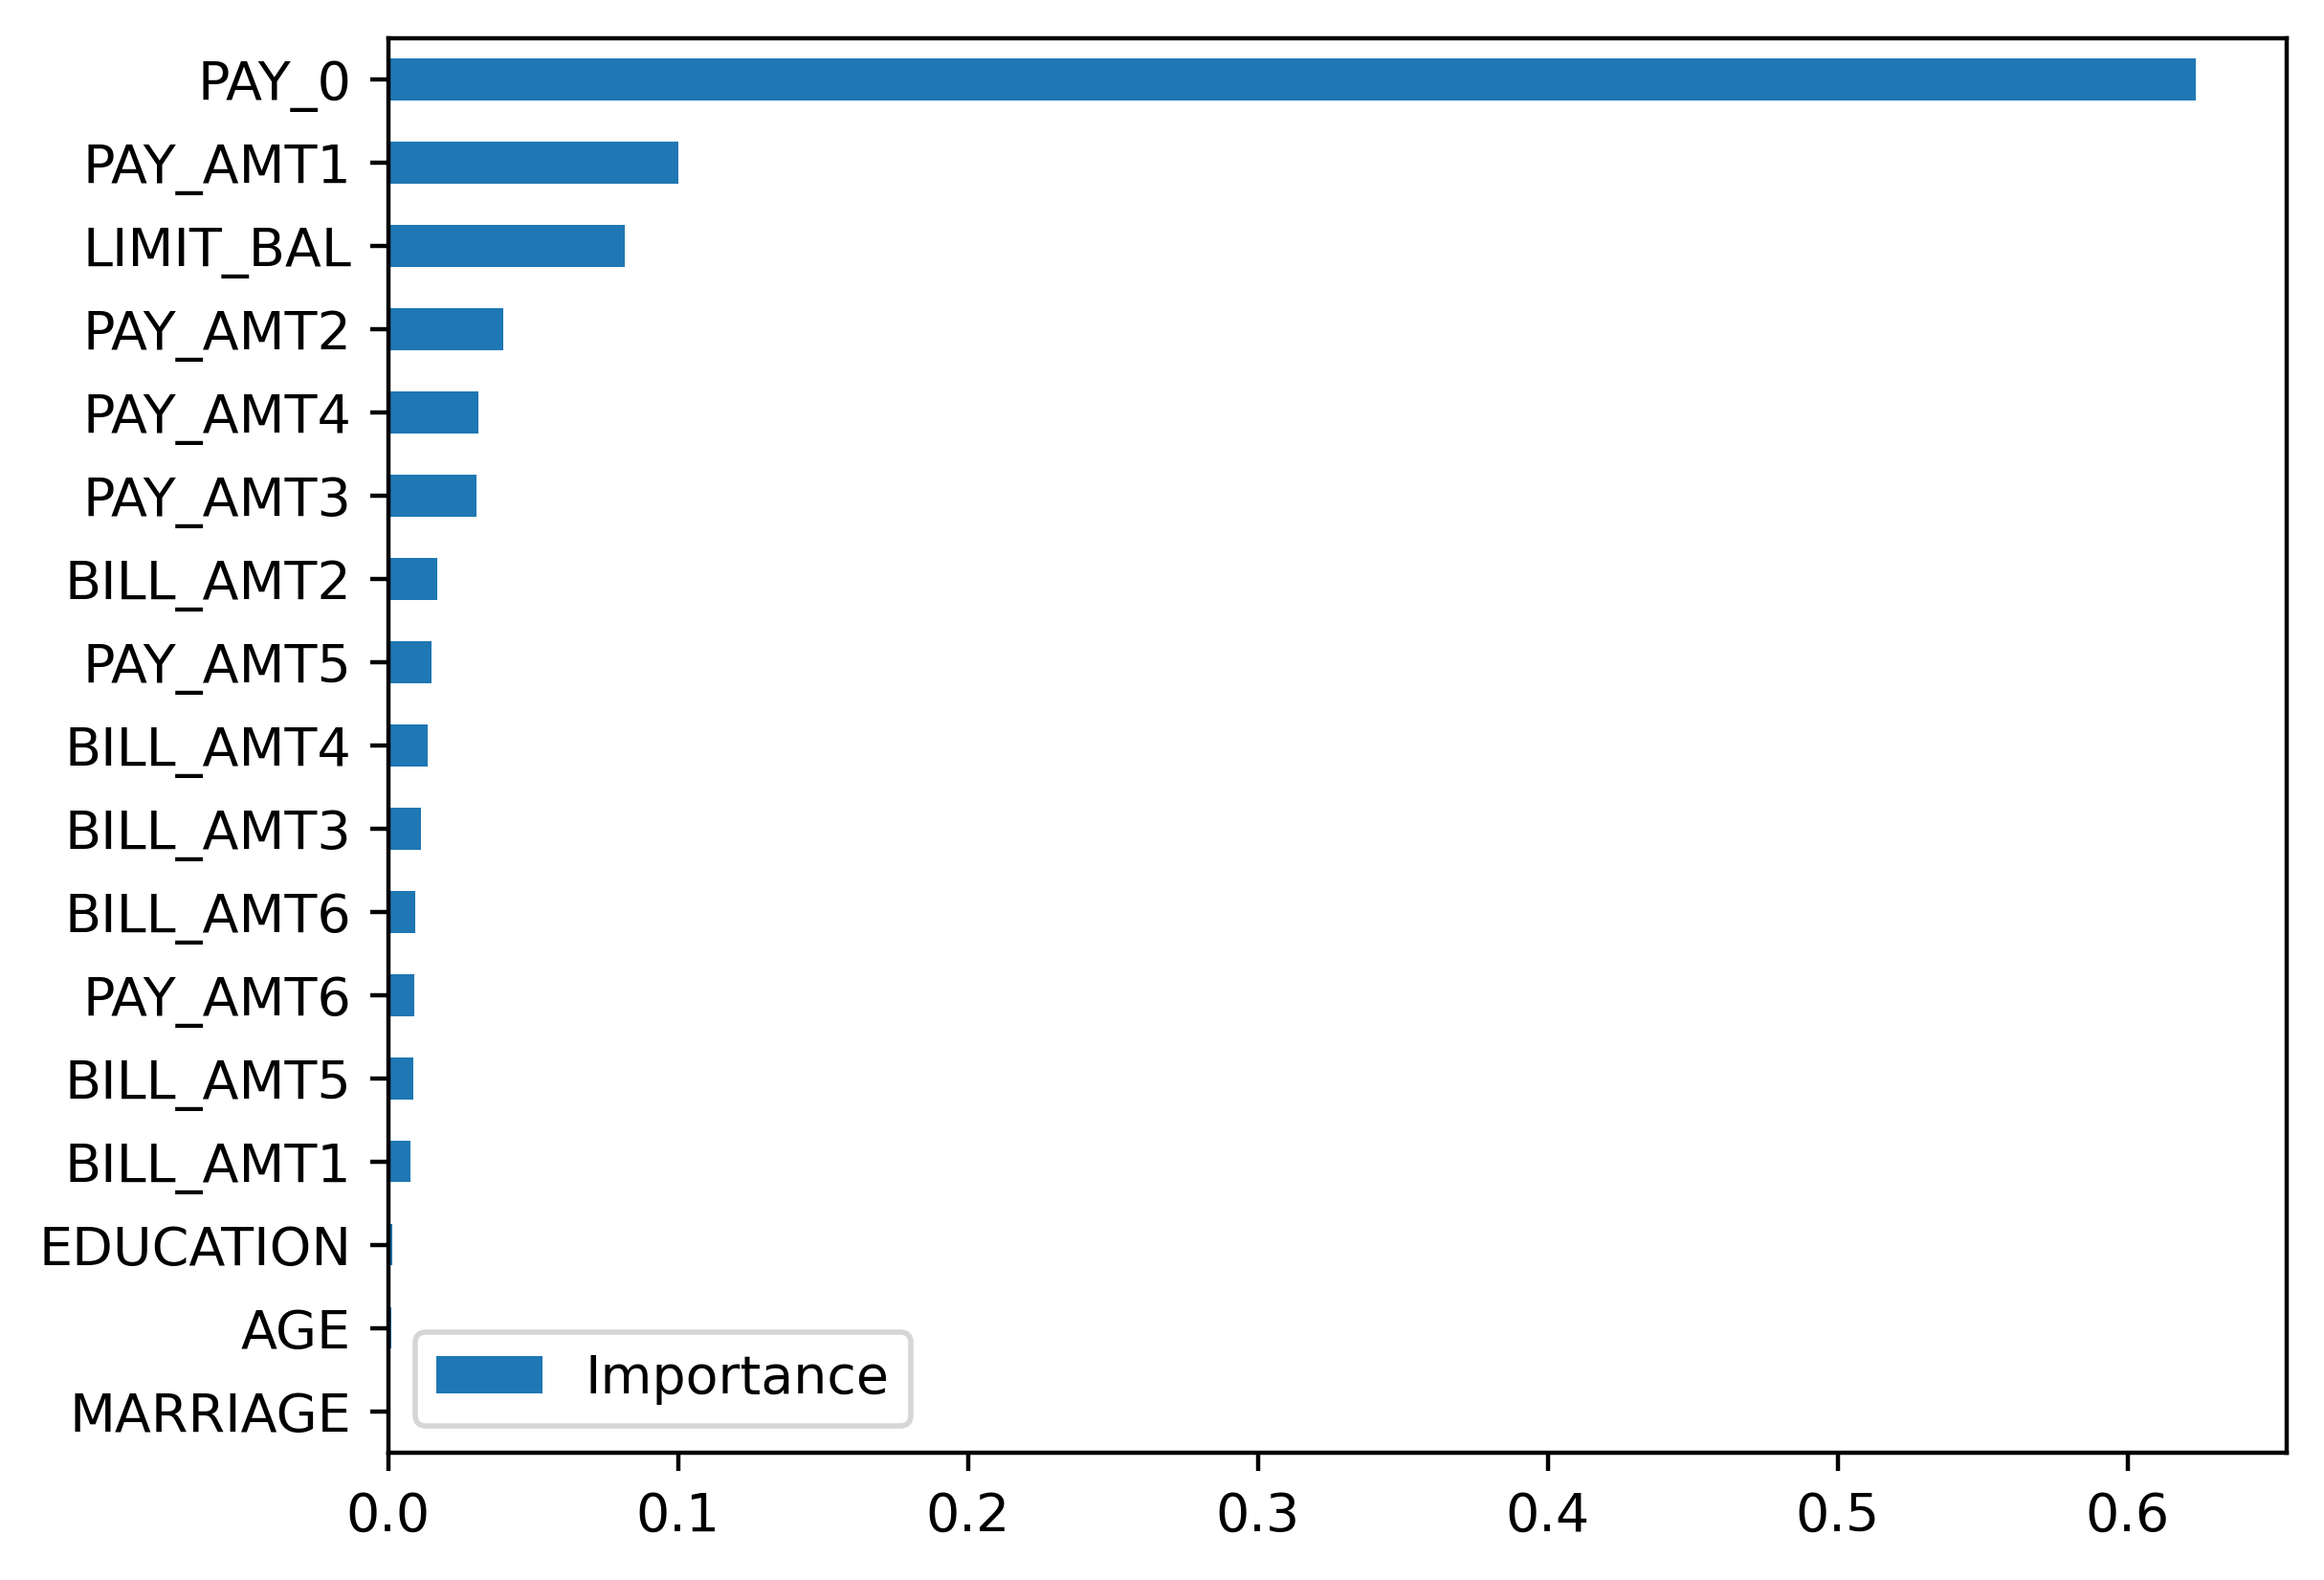

In [ ]:

# 4) GridSearchCV cho max_depth
params = {'max_depth':[1,2,4,6,8,10,12]}
cv = GridSearchCV(tree.DecisionTreeClassifier(), param_grid=params,
                  scoring='roc_auc', refit=True, cv=4, return_train_score=True)
cv.fit(X_train, y_train)

# 5) Rừng cây + GridSearch số cây
rf = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=3,
                            random_state=4)
rf_params_ex = {'n_estimators': list(range(10,110,10))}
cv_rf_ex = GridSearchCV(rf, param_grid=rf_params_ex, scoring='roc_auc',
                        refit=True, cv=4, return_train_score=True)
cv_rf_ex.fit(X_train, y_train)

# Vẽ kết quả
cv_results_df = pd.DataFrame(cv.cv_results_)
ax = plt.axes()
ax.errorbar(cv_results_df['param_max_depth'], cv_results_df['mean_train_score'],
            yerr=cv_results_df['std_train_score']/np.sqrt(4), label='Train')
ax.errorbar(cv_results_df['param_max_depth'], cv_results_df['mean_test_score'],
            yerr=cv_results_df['std_test_score']/np.sqrt(4), label='Test')
ax.legend(); plt.xlabel('max_depth'); plt.ylabel('ROC AUC')

cv_rf_ex_results_df = pd.DataFrame(cv_rf_ex.cv_results_)
fig, axs = plt.subplots(1,2, figsize=(6,3))
axs[0].plot(cv_rf_ex_results_df['param_n_estimators'], cv_rf_ex_results_df['mean_fit_time'], '-o')
axs[0].set_xlabel('Number of trees'); axs[0].set_ylabel('Mean fit time (s)')
axs[1].errorbar(cv_rf_ex_results_df['param_n_estimators'], cv_rf_ex_results_df['mean_test_score'],
                yerr=cv_rf_ex_results_df['std_test_score']/np.sqrt(4))
axs[1].set_xlabel('Number of trees'); axs[1].set_ylabel('Mean testing ROC AUC ± 1SE')
plt.tight_layout()

# Feature importance (best RF)
feat_imp_df = pd.DataFrame({'Importance': cv_rf_ex.best_estimator_.feature_importances_},
                           index=features_response[:-1])
feat_imp_df.sort_values('Importance', ascending=True).plot.barh();


#### 2.1.3. Bài tập thực hành 1 — **Titanic (Kaggle)**

Original columns: Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')
Numerical columns: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Categorical columns: ['Sex', 'Embarked']
Shape of X after preprocessing: (891, 11)
Shape of X_train: (712, 11)
Shape of y_train: (712,)


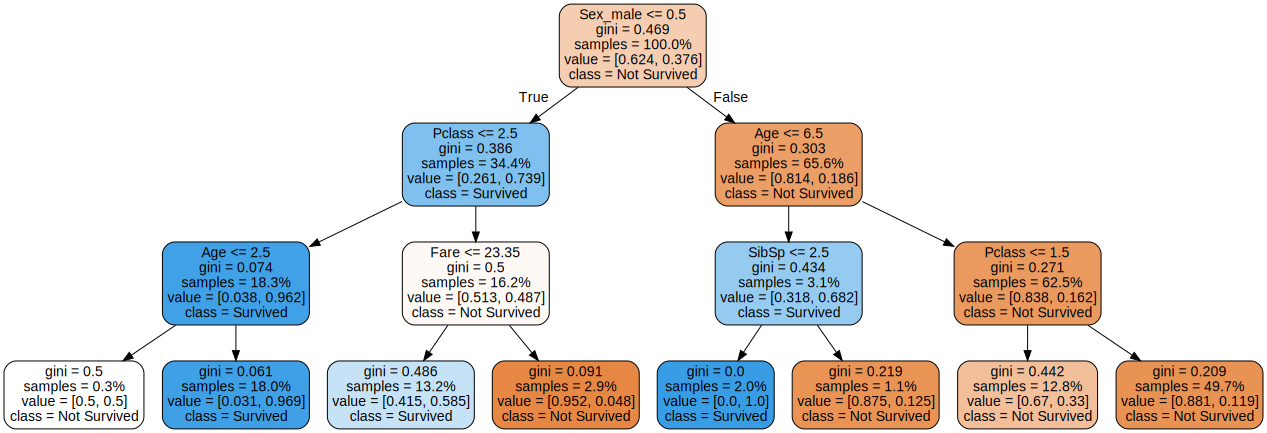

In [ ]:
# === Xây dựng Cây quyết định cho dữ liệu Titanic dựa trên mẫu ===
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import graphviz
from sklearn import tree

# 1) Tải dữ liệu
df_titanic = pd.read_csv('data_Lab2/titanic.csv')
y = df_titanic['Survived']
# Select feature columns
feature_cols = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X = df_titanic[feature_cols]


print("Original columns:", X.columns)

num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

print("Numerical columns:", num_cols)
print("Categorical columns:", cat_cols)


preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', 'passthrough', num_cols) # Explicitly include numerical columns
])

# Chia dữ liệu sau tiền xử lý
X_processed = preprocess.fit_transform(X)
print("Shape of X after preprocessing:", X_processed.shape)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)


# 3) Cây quyết định
# Sử dụng các tham số tương tự bài mẫu hoặc điều chỉnh nếu cần
dt_titanic = tree.DecisionTreeClassifier(max_depth=3, random_state=42) # Adjusted max_depth for potentially better visualization
dt_titanic.fit(X_train, y_train)

# Trực quan hóa cây quyết định
# Cần lấy tên đặc trưng sau khi tiền xử lý (OneHotEncoder)
# Lấy tên cột sau khi OneHotEncoder - cần fit_transform trước để có tên cột
preprocess.fit(X) # Fit the preprocessor to get feature names
ohe_feature_names = preprocess.transformers_[0][1].get_feature_names_out(cat_cols)
all_feature_names = list(ohe_feature_names) + num_cols


dot_data_titanic = tree.export_graphviz(
    dt_titanic, out_file=None, filled=True, rounded=True,
    feature_names=all_feature_names, # Sử dụng tên đặc trưng đã tiền xử lý
    proportion=True,
    class_names=['Not Survived', 'Survived']) # Điều chỉnh tên lớp cho bài toán Titanic

graph_titanic = graphviz.Source(dot_data_titanic)
graph_titanic

Random Forest Model Performance on Titanic Data:
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       105
           1       0.81      0.70      0.75        74

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179



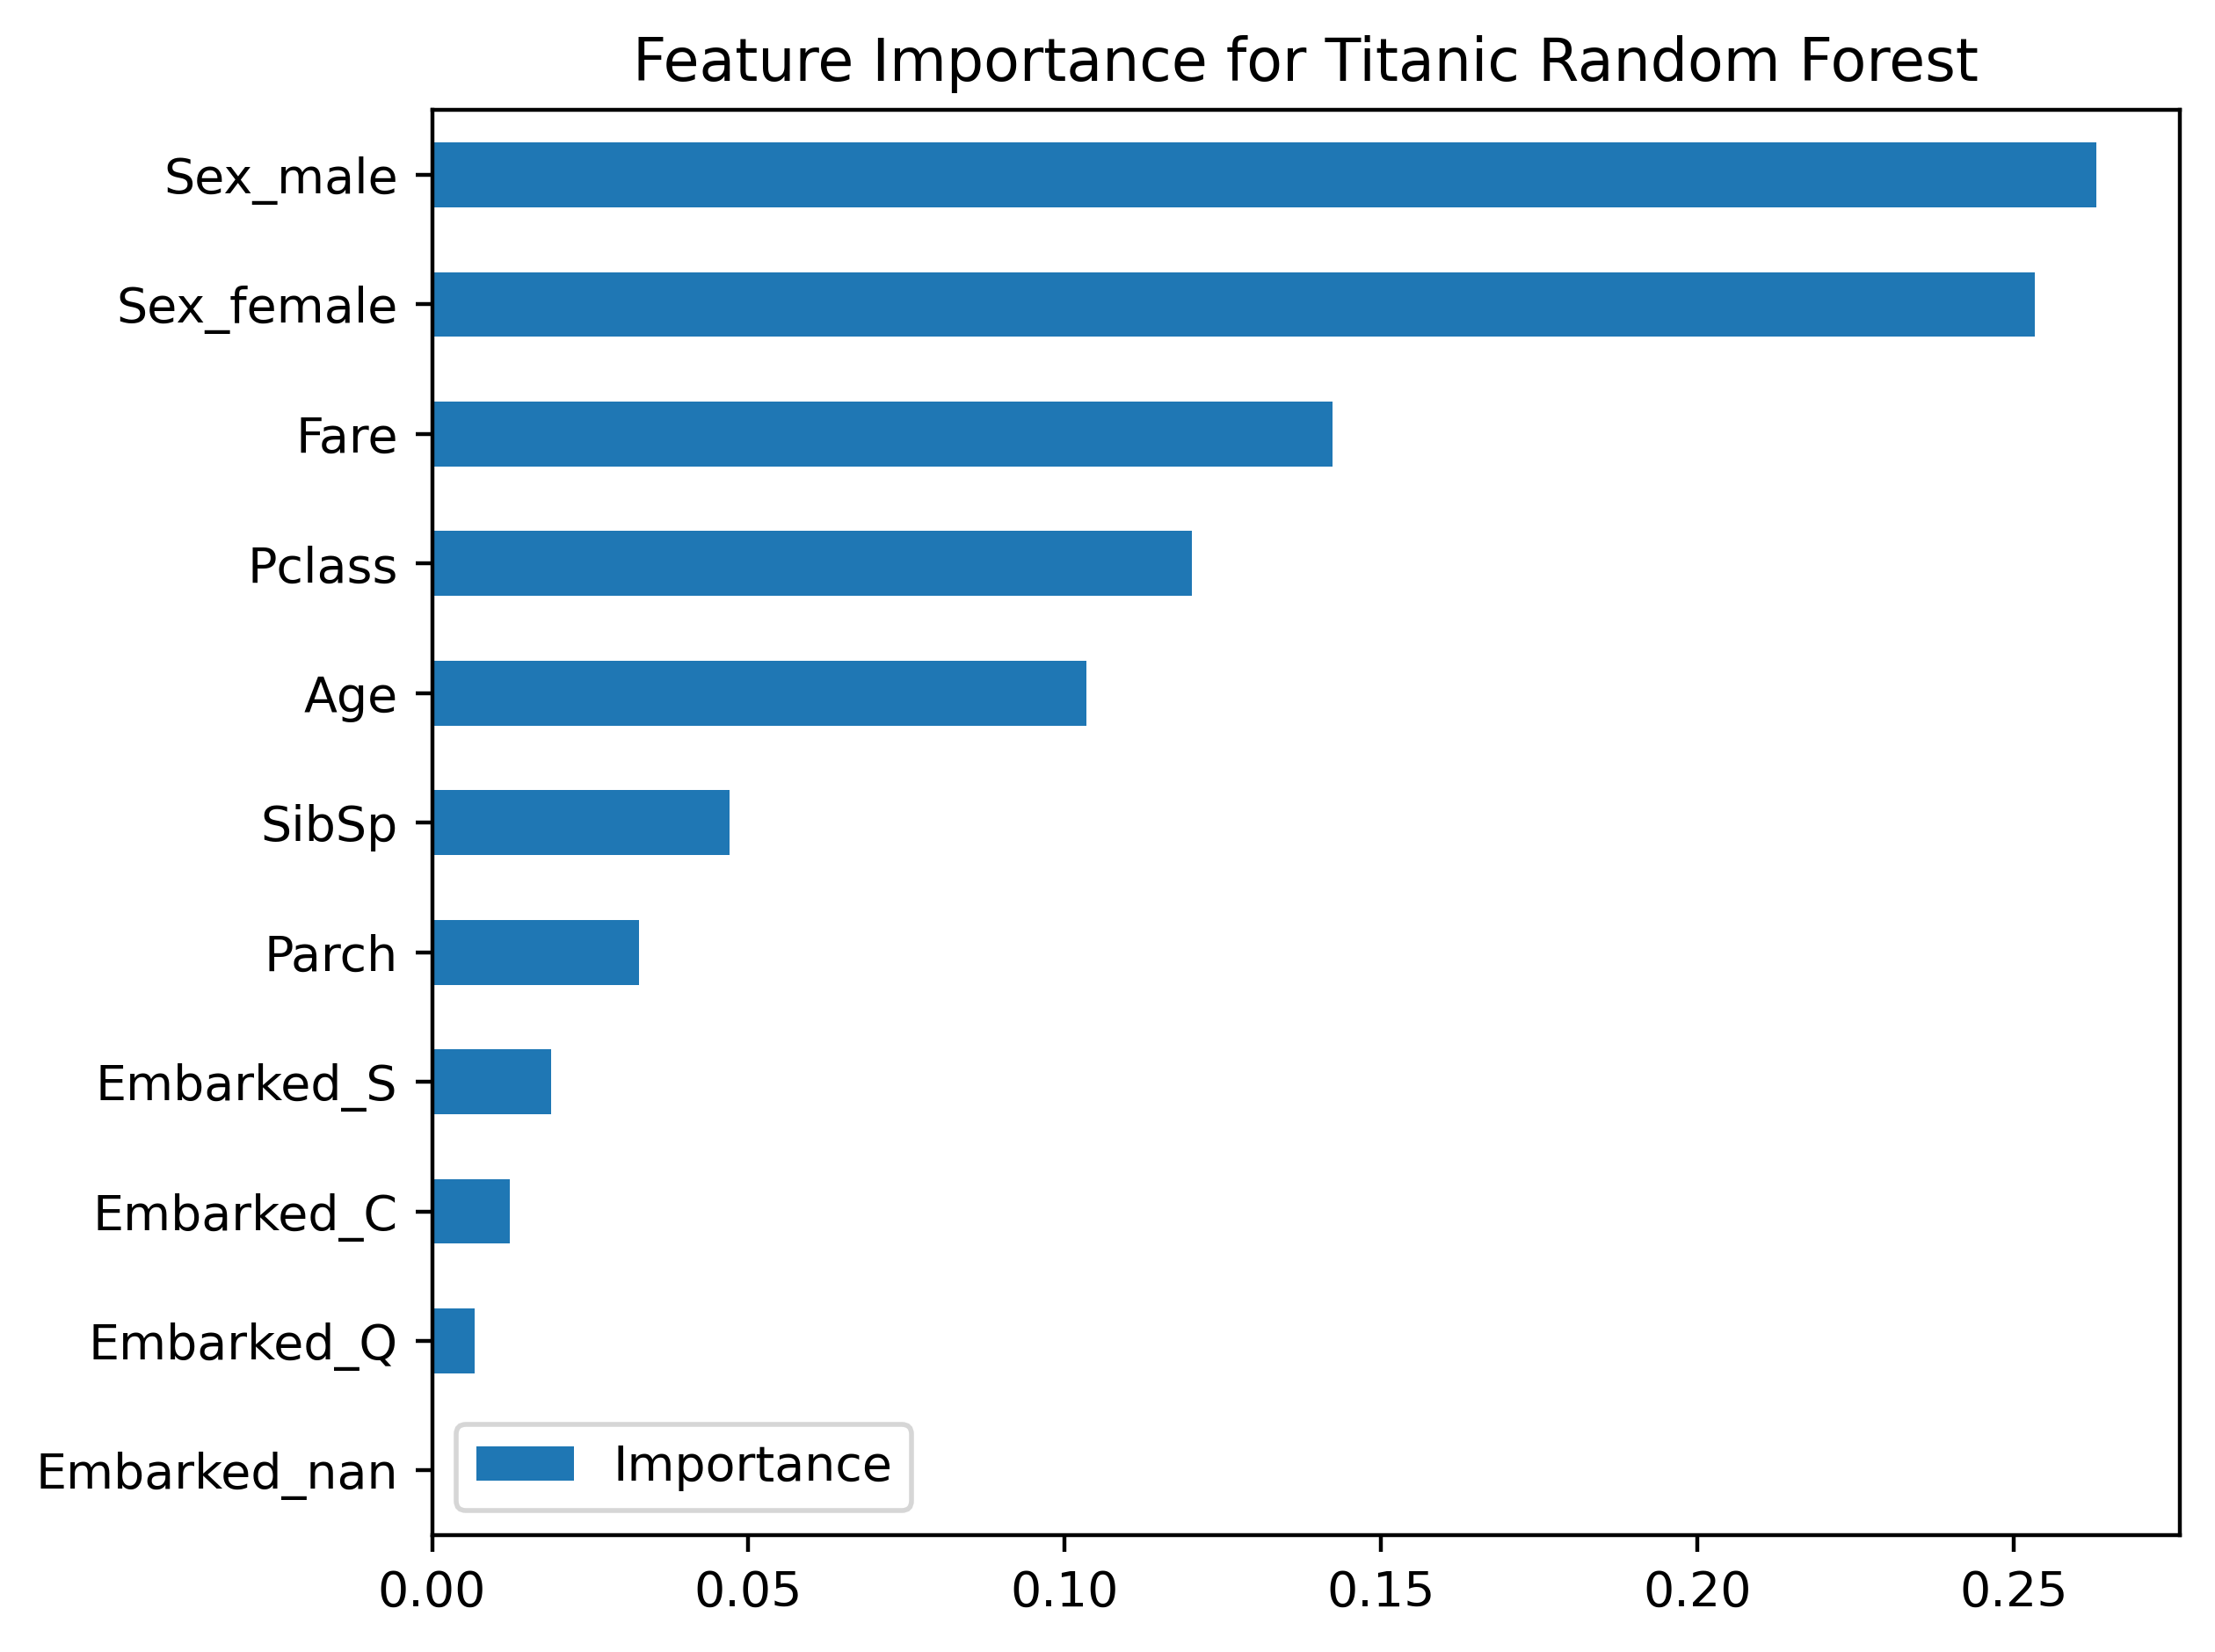

In [ ]:
# === Xây dựng Rừng cây quyết định cho dữ liệu Titanic dựa trên mẫu ===
# Tiếp tục sử dụng dữ liệu đã được tiền xử lý X_train, X_test, y_train, y_test từ bài tập trước

# 4) Random Forest
# Sử dụng các tham số tương tự bài mẫu hoặc điều chỉnh nếu cần
rf_titanic = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=5,
                                    random_state=42) # Adjusted parameters
rf_titanic.fit(X_train, y_train)

# Đánh giá mô hình
print("Random Forest Model Performance on Titanic Data:")
print(classification_report(y_test, rf_titanic.predict(X_test)))

# Feature importance (best RF) - Sử dụng best_estimator_ nếu dùng GridSearchCV, ở đây dùng trực tiếp rf_titanic
# Lấy tên đặc trưng sau khi tiền xử lý (đã tạo ở cell trước)
# all_feature_names = list(preprocess.transformers_[0][1].get_feature_names_out(cat_cols)) + num_cols

feat_imp_df_titanic = pd.DataFrame({'Importance': rf_titanic.feature_importances_},
                           index=all_feature_names) # Sử dụng tên đặc trưng đã tiền xử lý
feat_imp_df_titanic.sort_values('Importance', ascending=True).plot.barh(title='Feature Importance for Titanic Random Forest');
plt.tight_layout()
plt.show()

# Nếu muốn tối ưu siêu tham số cho Random Forest, có thể thêm GridSearchCV tương tự bài mẫu credit.csv
# Ví dụ:
# param_rf_titanic = {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10]}
# gs_rf_titanic = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=param_rf_titanic,
#                             scoring='f1', cv=5) # Chọn scoring phù hợp
# gs_rf_titanic.fit(X_train, y_train)
# print('Best RF Titanic:', gs_rf_titanic.best_params_)
# print(classification_report(y_test, gs_rf_titanic.predict(X_test)))

#### 2.1.4. Bài tập thực hành 2 — **Pima Indians Diabetes**

In [ ]:
 # === THỰC HÀNH: Diabetes RF/DT ===
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# 1) Nạp dữ liệu (diabetes.csv)
df = pd.read_csv('data_Lab2/diabetes.csv')
X = df.drop('diabetes', axis=1)
y = df['diabetes']

# Identify numerical and categorical columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

# Create a preprocessor to handle numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='passthrough' # Keep other columns (if any) - though none expected here
)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2) Decision Tree
dt_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('dt', DecisionTreeClassifier(random_state=42))
])
param_dt = {'dt__max_depth':[None,3,5,7,9], 'dt__min_samples_leaf':[1,3,5,10]}
gs_dt = GridSearchCV(dt_pipe, param_dt, cv=5, scoring='f1')
gs_dt.fit(X_train, y_train)
print('Best DT:', gs_dt.best_params_)
print(classification_report(y_test, gs_dt.predict(X_test)))



Best DT: {'dt__max_depth': 9, 'dt__min_samples_leaf': 5}
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18300
           1       0.98      0.68      0.80      1700

    accuracy                           0.97     20000
   macro avg       0.98      0.84      0.89     20000
weighted avg       0.97      0.97      0.97     20000



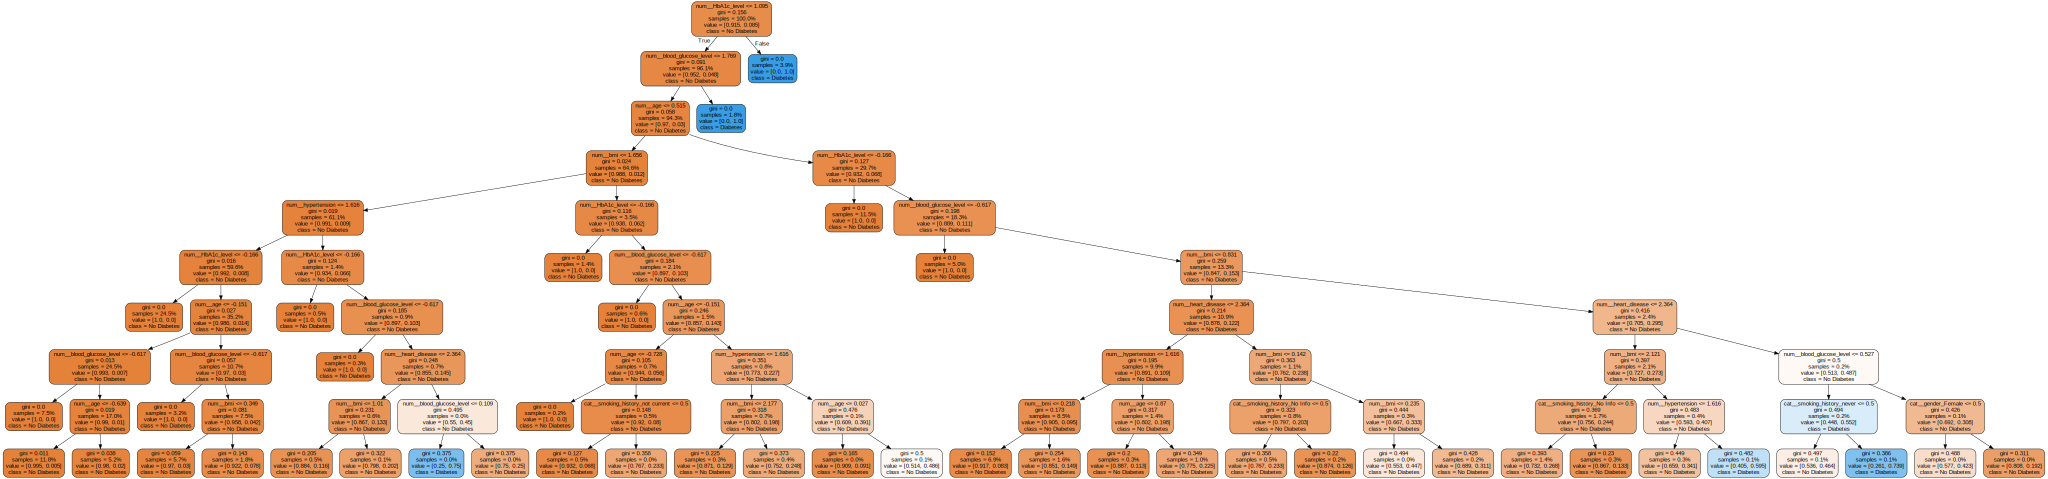

In [ ]:
# Trực quan hóa cây quyết định cho bài toán Diabetes (sau khi train dt_pipe)
# Cần lấy tên đặc trưng sau khi tiền xử lý từ preprocessor trong pipeline
# Cách lấy tên đặc trưng sau khi OneHotEncoder:
# preprocessor trong pipeline đã được fit khi gs_dt.fit() chạy.
# Lấy transformer 'cat' và dùng get_feature_names_out()

# Lấy tên cột sau khi tiền xử lý (OneHotEncoder + passthrough)
# Access the fitted preprocessor from the best estimator pipeline
fitted_preprocessor = gs_dt.best_estimator_.named_steps['preprocessor']

# Get feature names out after preprocessing
# Note: get_feature_names_out() is the standard way in newer scikit-learn versions
# It automatically handles both one-hot encoded and passthrough columns
all_feature_names_diabetes = fitted_preprocessor.get_feature_names_out()


# Lấy mô hình cây quyết định đã train từ pipeline tốt nhất
best_dt_model = gs_dt.best_estimator_.named_steps['dt']


dot_data_diabetes = tree.export_graphviz(
    best_dt_model, out_file=None, filled=True, rounded=True,
    feature_names=all_feature_names_diabetes, # Sử dụng tên đặc trưng đã tiền xử lý
    proportion=True,
    class_names=['No Diabetes', 'Diabetes']) # Điều chỉnh tên lớp

graph_diabetes = graphviz.Source(dot_data_diabetes)
graph_diabetes

In [ ]:
# 3) Random Forest
rf_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(random_state=42))
])
param_rf = {'rf__n_estimators':[200,400], 'rf__max_depth':[None,6,10], 'rf__min_samples_leaf':[1,3,5]}
gs_rf = GridSearchCV(rf_pipe, param_rf, cv=5, scoring='f1')
gs_rf.fit(X_train, y_train)
print('Best RF:', gs_rf.best_params_)
print(classification_report(y_test, gs_rf.predict(X_test)))

Best RF: {'rf__max_depth': None, 'rf__min_samples_leaf': 5, 'rf__n_estimators': 200}
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18300
           1       0.99      0.68      0.81      1700

    accuracy                           0.97     20000
   macro avg       0.98      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000




---
### 2.2. GIẢI THUẬT 2: SUPPORT VECTOR MACHINE (SVM)

#### 2.2.1. Ôn tập lý thuyết
- Ý tưởng: tìm **siêu phẳng (hyperplane)** tối đa hóa **lề (margin)**.  
- **Support vectors**: các điểm nằm sát lề, quyết định biên.  
- **Hard vs Soft margin**; vai trò tham số **C**.  
- **Kernel**: linear, polynomial, RBF… khi nào dùng loại nào.  
- Cần **chuẩn hóa** dữ liệu trước SVM; đánh giá qua CV, grid search.


#### 2.2.2. Bài làm mẫu (GIỮ NGUYÊN CODE MẪU Lab02) — Iris & MNIST

##### Bài toán 1: Thực hiện các nhiệm vụ trong bài toán 1 để xây dựng mô hình với giải thuật SVM

In [ ]:

# === Code mẫu GIỮ NGUYÊN từ Lab02 ===
import numpy as np
from sklearn import datasets, svm
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
print(iris.DESCR)

data = iris.data
target = iris.target
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=101)

clf = svm.SVC()
clf.fit(X_train, y_train)
print('Training accuracy:', clf.score(X_train,y_train))
print('Validation accuracy:', clf.score(X_test,y_test))

kernels = ['linear','poly','rbf','sigmoid']
best_svm, best_val_acc, best_kernel = None, -1, None
for k in kernels:
    clf = svm.SVC(kernel=k, probability=True)
    clf.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    if acc > best_val_acc:
        best_val_acc, best_svm, best_kernel = acc, clf, k
print('Best validation accuracy:', best_val_acc, 'with kernel:', best_kernel)


.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

##### Bài toán 2:  Xây dựng mô hình dựa vào giải thuật SVM trên dữ liệu hình ảnh

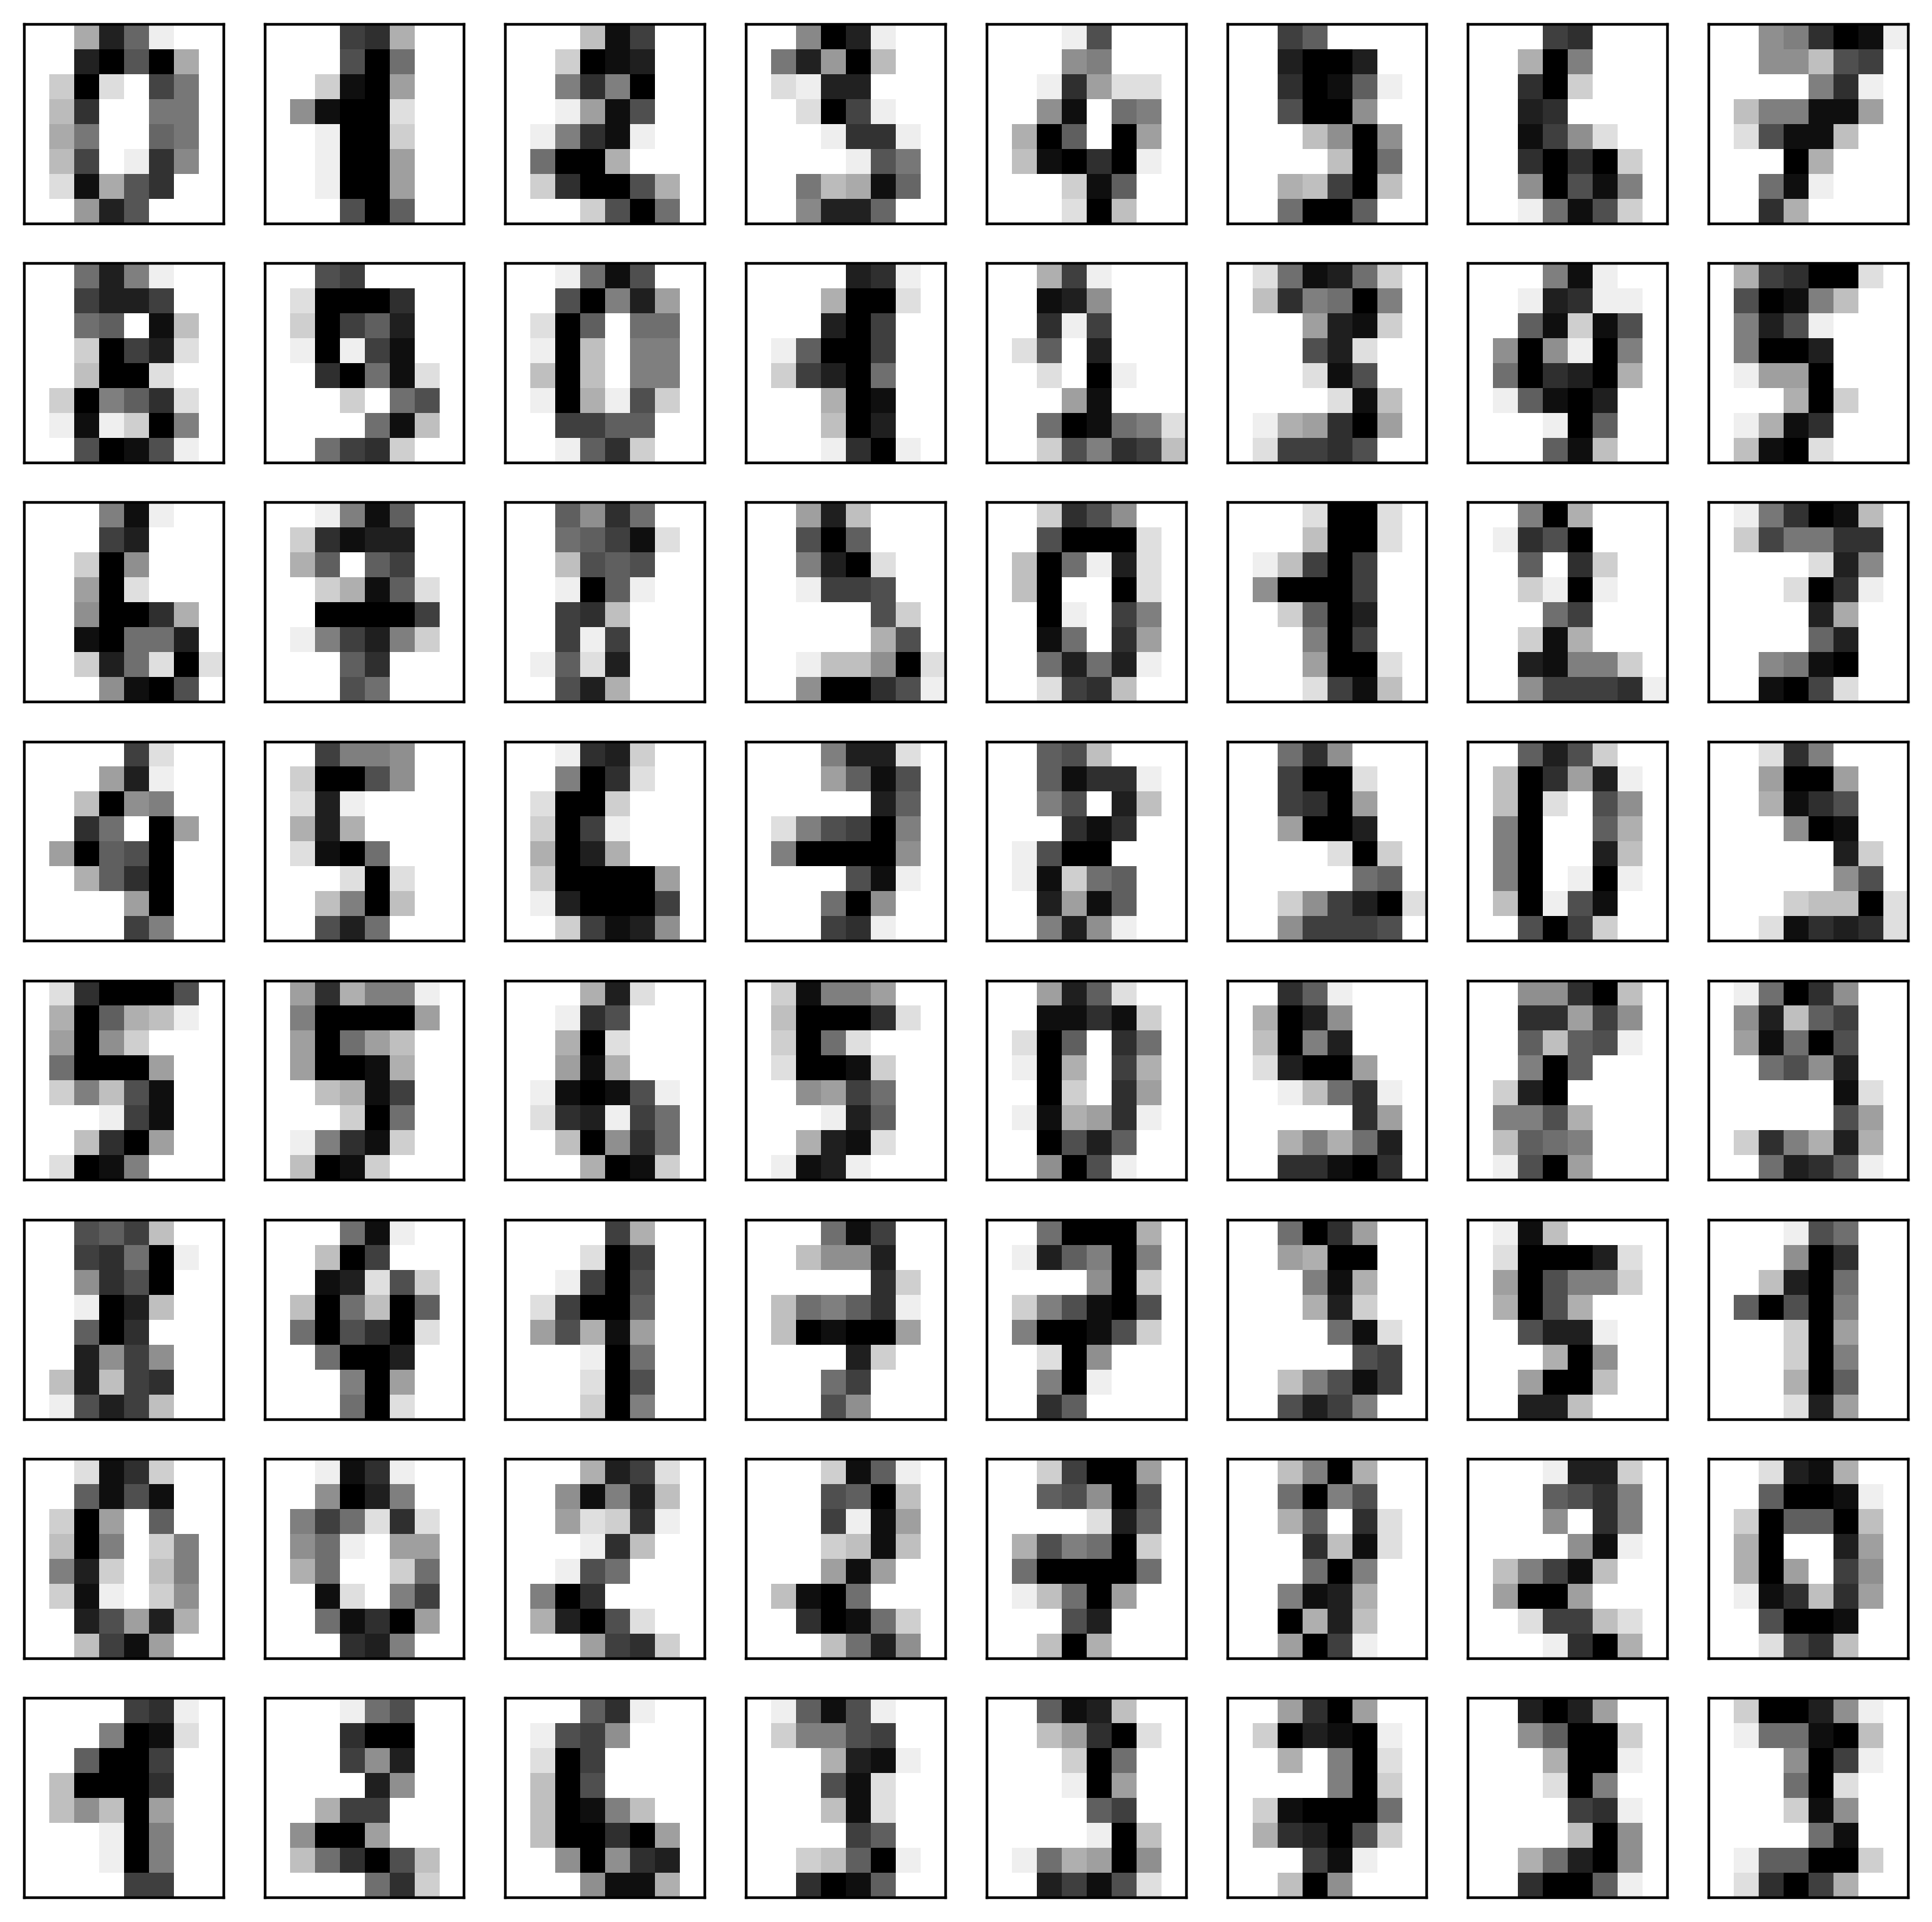

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
digits = load_digits(n_class=10)

#thông tin toàn bộ dữ liệu đã tải về
digits
#xem thông tin của một hình dưới dạng ma trận 8 x 8
digits['data'][0].reshape(8,8)

#xem thông tin của một hình dưới dạng mảng
digits['data'][0]
#xem thông tin 9 nhãn đầu tiên
digits['target'][0:9]

# Each Digit is represented in digits.images as a matrix of 8x8 = 64 pixels. Each of the 64 values represent
# a greyscale. The Greyscale are then plotted in the right scale by the imshow method.
fig, ax = plt.subplots(8,8, figsize=(10,10))
for i, axi in enumerate(ax.flat):
    axi.imshow(digits.images[i], cmap='binary')
    axi.set(xticks=[], yticks=[])


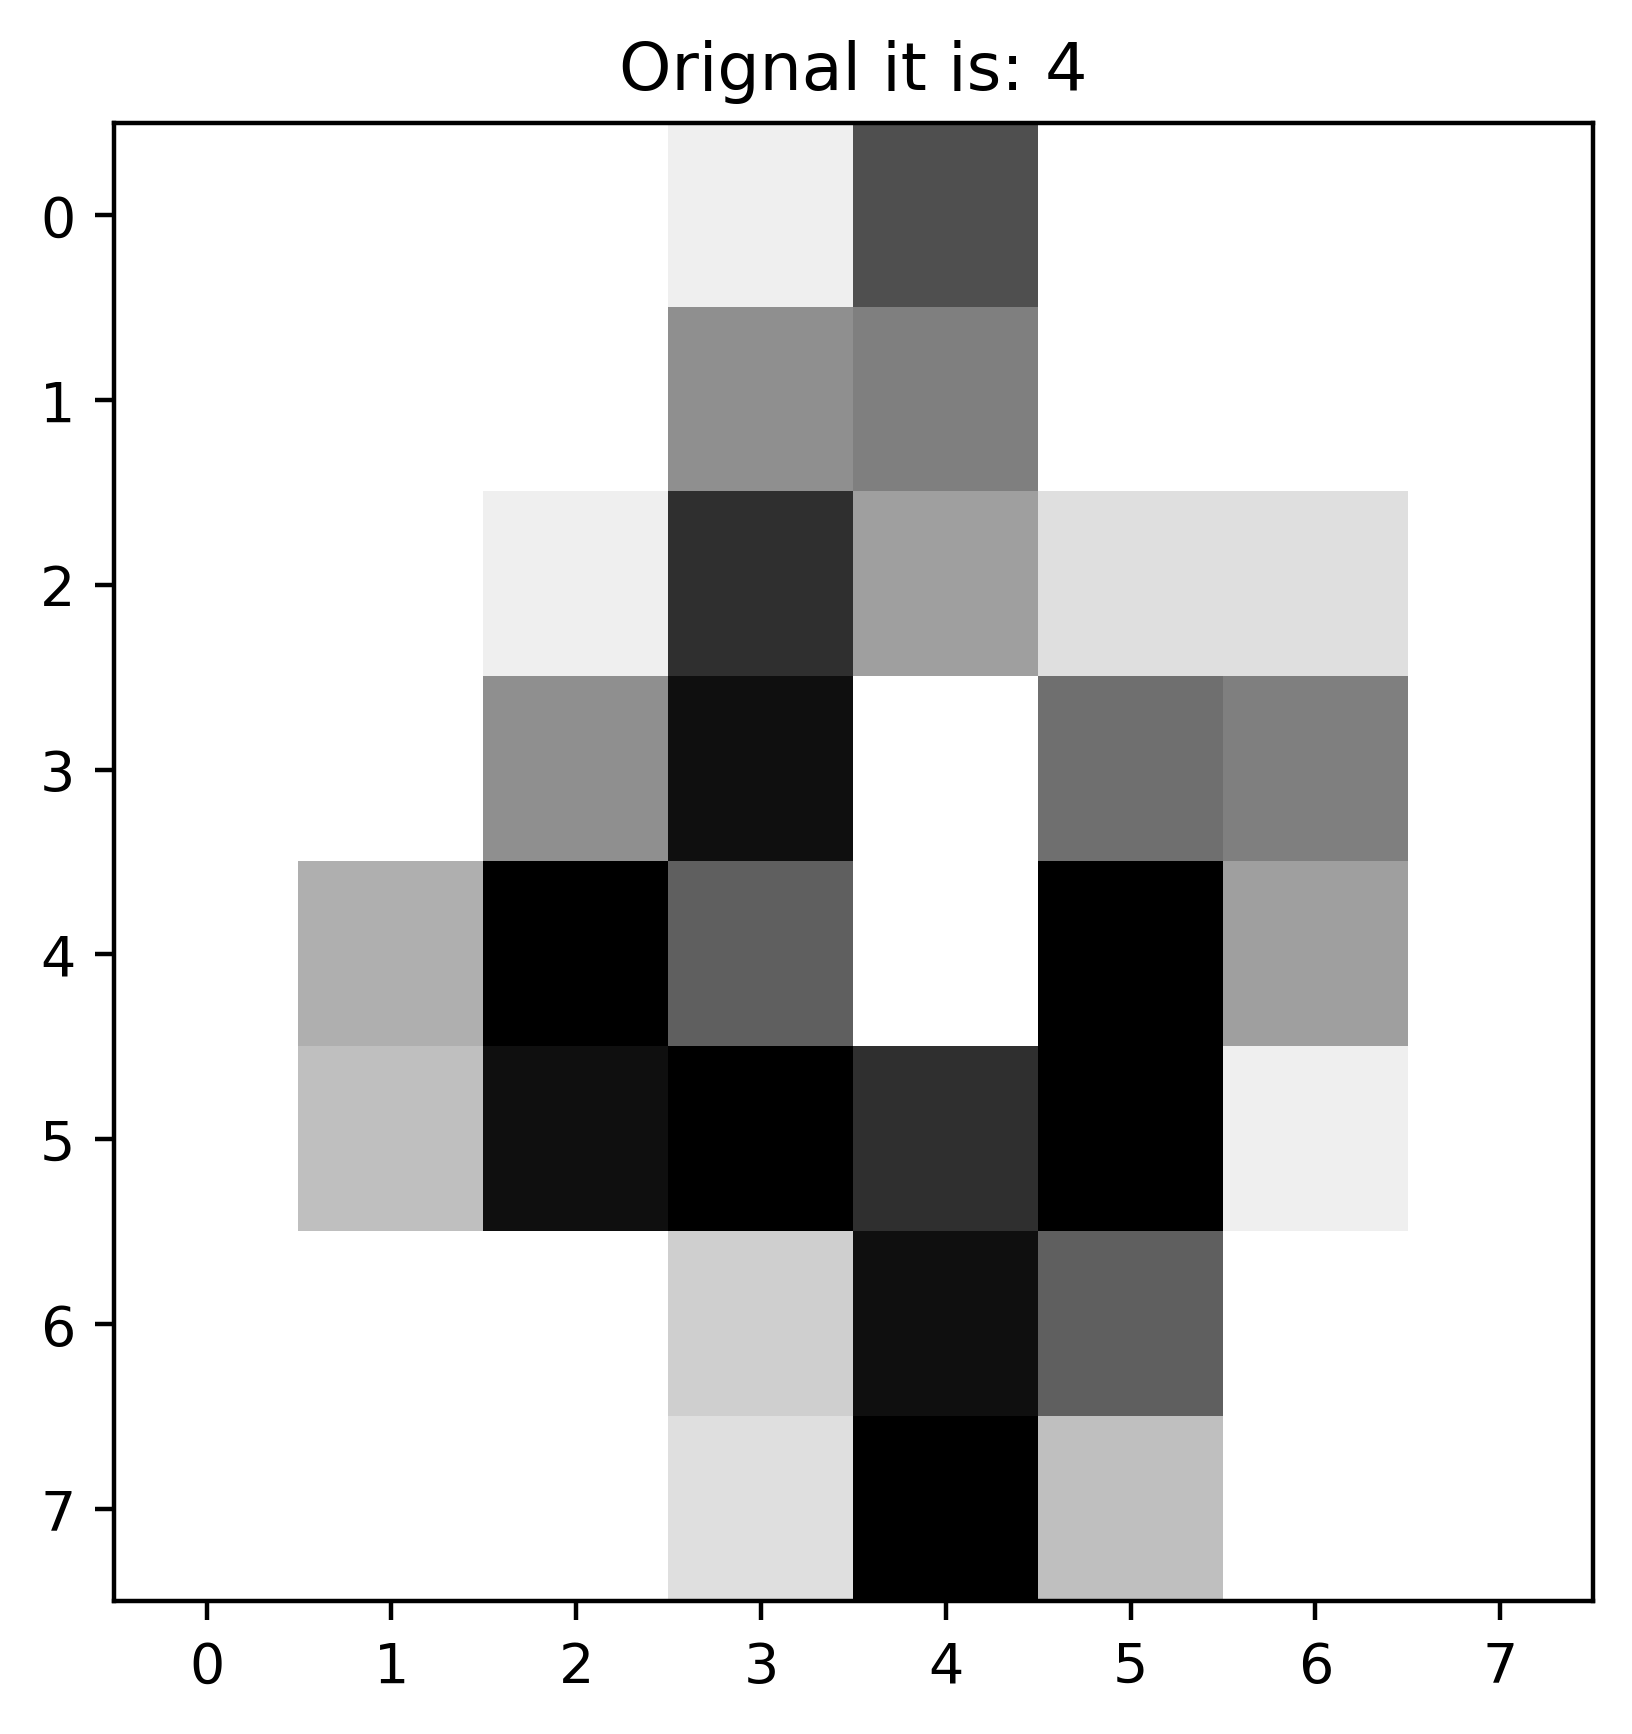

In [ ]:
# Hàm vẽ 1 ảnh có kích thước 8 x 8 (ảnh lấy từ ma images)
def view_digit(index):
 plt.imshow(digits.images[index] , cmap = plt.cm.gray_r)
 plt.title('Orignal it is: '+ str(digits.target[index]))
 plt.show()
# vẽ ảnh ở vị trí thứ 4
view_digit(4)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        26
           1       1.00      0.94      0.97        32
           2       1.00      1.00      1.00        27
           3       0.80      1.00      0.89        24
           4       0.91      0.97      0.94        31
           5       1.00      0.91      0.95        33
           6       1.00      1.00      1.00        30
           7       1.00      1.00      1.00        30
           8       0.93      0.84      0.88        31
           9       0.94      0.91      0.92        32

    accuracy                           0.95       296
   macro avg       0.95      0.96      0.95       296
weighted avg       0.96      0.95      0.95       296



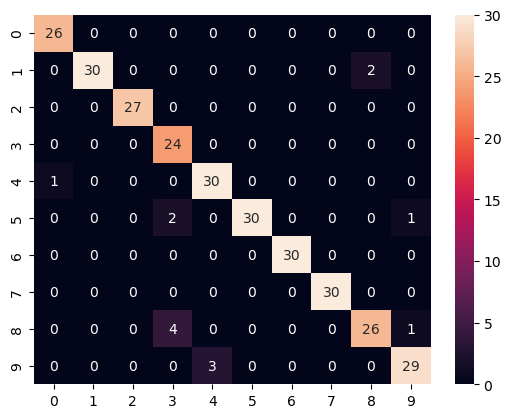

In [ ]:

# === Code mẫu GIỮ NGUYÊN từ Lab02 (MNIST/Digits) ===
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

digits = load_digits(n_class=10)
svc = svm.SVC(gamma=0.001, C=100)
svc.fit(digits.data[:1500], digits.target[:1500])
pred = svc.predict(digits.data[1501:])
cm = confusion_matrix(pred, digits.target[1501:])
sns.heatmap(pd.DataFrame(cm), annot=True, fmt='d');
print(classification_report(pred, digits.target[1501:]))


#### 2.2.3. Bài tập thực hành 1 — **Pima Indians Diabetes (SVM)**

In [ ]:
import pandas as pd

# Load the dataset (assuming diabetes.csv based on context)
df_diabetes = pd.read_csv('data_Lab2/diabetes.csv')

# Display the column names
print("Columns in diabetes.csv:")
print(df_diabetes.columns.tolist())

# Display the first few rows to see the data
print("\nFirst 5 rows of diabetes.csv:")
display(df_diabetes.head())

Columns in diabetes.csv:
['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']

First 5 rows of diabetes.csv:


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [ ]:
# === THỰC HÀNH: Diabetes SVM ===
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report

df = pd.read_csv('data_Lab2/diabetes.csv')
X, y = df.drop('diabetes', axis=1), df['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)

# Identify numerical and categorical columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

# Create a preprocessor to handle numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='passthrough' # Keep other columns (if any) - though none expected here
)


pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('svc', SVC())
])
param = {
    'svc__kernel':['rbf','linear'],
    'svc__C':[1, 10], # Reduced C values
    'svc__gamma':['scale'] # Reduced gamma values
}
cv = GridSearchCV(pipe, param, cv=5, scoring='f1')
cv.fit(X_train, y_train)
print('Best SVM:', cv.best_params_)
print(classification_report(y_test, cv.predict(X_test)))

#### 2.2.4. Bài tập thực hành 2 — **Animal Condition (SVM)**

In [ ]:
import pandas as pd

# Load the dataset
df_animal = pd.read_csv('data_Lab2/animal.csv')

# Display the column names
print("Columns in animal.csv:")
print(df_animal.columns.tolist())

# Display the first few rows to see the data
print("\nFirst 5 rows of animal.csv:")
display(df_animal.head())

Columns in animal.csv:
['AnimalName', 'symptoms1', 'symptoms2', 'symptoms3', 'symptoms4', 'symptoms5', 'Dangerous']

First 5 rows of animal.csv:


,AnimalName,symptoms1,symptoms2,symptoms3,symptoms4,symptoms5,Dangerous
0,Dog,Fever,Diarrhea,Vomiting,Weight loss,Dehydration,Yes
1,Dog,Fever,Diarrhea,Coughing,Tiredness,Pains,Yes
2,Dog,Fever,Diarrhea,Coughing,Vomiting,Anorexia,Yes
3,Dog,Fever,Difficulty breathing,Coughing,Lethargy,Sneezing,Yes
4,Dog,Fever,Diarrhea,Coughing,Lethargy,Blue Eye,Yes


In [ ]:
# === THỰC HÀNH: Animal Condition SVM ===
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Thay bằng đường dẫn file của bạn
df = pd.read_csv('data_Lab2/animal.csv')

# Chuyển đổi cột mục tiêu 'Dangerous' sang dạng số
df['Dangerous'] = df['Dangerous'].map({'Yes': 1, 'No': 0})

# Xử lý giá trị thiếu (NaN) trong cột mục tiêu 'Dangerous'
# Kiểm tra số lượng NaN trước khi xử lý
print(f"Số lượng giá trị thiếu trong cột 'Dangerous' trước khi xử lý: {df['Dangerous'].isnull().sum()}")
# Loại bỏ các dòng có giá trị thiếu trong cột mục tiêu
df.dropna(subset=['Dangerous'], inplace=True)
print(f"Số lượng giá trị thiếu trong cột 'Dangerous' sau khi xử lý: {df['Dangerous'].isnull().sum()}")


# Giả sử cột mục tiêu tên 'condition' (điều chỉnh theo thực tế)
y = df['Dangerous'] # Đã sửa tên cột mục tiêu thành 'Dangerous'
X = df.drop(columns=['Dangerous']) # Đã sửa tên cột mục tiêu thành 'Dangerous'

num_cols = X.select_dtypes(include=['int64','float64']).columns
# Thêm 'object' vào include để bắt các cột string như 'AnimalName' và 'symptoms'
cat_cols = X.select_dtypes(include=['object','bool','category']).columns

pre = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', StandardScaler(), num_cols)
])

pipe = Pipeline([
    ('pre', pre),
    ('svc', SVC())
])
# Giảm bớt không gian tìm kiếm để chạy nhanh hơn
param = {'svc__kernel':['rbf','linear'], 'svc__C':[1,10], 'svc__gamma':['scale']}
cv = GridSearchCV(pipe, param, cv=5, scoring='f1_weighted', n_jobs=-1) # Sử dụng n_jobs=-1 để tăng tốc
cv.fit(X, y)
print('Best:', cv.best_params_)
# Chia lại dữ liệu sau khi sửa tên cột
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(classification_report(y_te, cv.best_estimator_.fit(X_tr,y_tr).predict(X_te)))

Số lượng giá trị thiếu trong cột 'Dangerous' trước khi xử lý: 2
Số lượng giá trị thiếu trong cột 'Dangerous' sau khi xử lý: 0
Best: {'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         4
         1.0       1.00      1.00      1.00       170

    accuracy                           1.00       174
   macro avg       1.00      1.00      1.00       174
weighted avg       1.00      1.00      1.00       174




---
### 2.3. GIẢI THUẬT 3: NAIVE BAYES

#### 2.3.1. Ôn tập lý thuyết
- Định lý Bayes; giả định **độc lập có điều kiện** giữa các đặc trưng.  
- Các biến thể: **Gaussian**, **Multinomial**, **Bernoulli** – khi nào dùng.  
- Ứng dụng điển hình: phân loại văn bản/spam; tiền xử lý văn bản & vector hóa.


#### 2.3.2. Bài làm mẫu (GIỮ NGUYÊN CODE MẪU Lab02) — Spam/Ham

##### Bài toán 1: Xây dựng mô hình dữ liệu bằng giải thuật Bayes ngây thơ

In [ ]:
# === Code mẫu GIỮ NGUYÊN từ Lab02 ===
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

data = pd.read_csv('data_Lab2/spam.csv', encoding='latin-1')
data = data.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
data.columns = ['label', 'text']
X, y = data.drop('label', axis=1), data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train['text'])
X_test_vec = vectorizer.transform(X_test['text'])

clf = MultinomialNB().fit(X_train_vec, y_train)
y_pred = clf.predict(X_test_vec)
print('Accuracy:', accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9838565022421525
[[963   2]
 [ 16 134]]
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       965
        spam       0.99      0.89      0.94       150

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115



#### 2.3.3. Bài tập thực hành 1 — **Customer Behaviour (GaussianNB)**

In [ ]:
import pandas as pd

# Load the Customer Behaviour dataset
df_customer = pd.read_csv('data_Lab2/customer_behaviour.csv')

# Display the column names
print("Columns in customer_behavior.csv:")
print(df_customer.columns.tolist())

# Display the first few rows to see the data
print("\nFirst 5 rows of customer_behavior.csv:")
display(df_customer.head())

Columns in customer_behavior.csv:
['User ID', 'Gender', 'Age', 'EstimatedSalary', 'Purchased']

First 5 rows of customer_behavior.csv:


,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [ ]:
# === THỰC HÀNH: Customer Behaviour Naive Bayes ===
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

# Đường dẫn file của bạn
df = pd.read_csv('data_Lab2/customer_behaviour.csv')
# Giả sử cột mục tiêu tên 'label' (điều chỉnh theo thực tế)
y = df['Purchased'] # Đã sửa tên cột mục tiêu thành 'Purchased'
X = df.drop(columns=['Purchased']) # Đã sửa tên cột mục tiêu thành 'Purchased'

num_cols = X.select_dtypes(include=['int64','float64']).columns
cat_cols = X.select_dtypes(include=['object','category','bool']).columns

pre = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', StandardScaler(), num_cols)
])

pipe = Pipeline([
    ('pre', pre),
    ('nb', GaussianNB())
])

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)
pipe.fit(X_train, y_train)
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90        51
           1       0.85      0.79      0.82        29

    accuracy                           0.88        80
   macro avg       0.87      0.86      0.86        80
weighted avg       0.87      0.88      0.87        80



#### 2.3.4. Bài tập thực hành 2 — **Mushroom (MultinomialNB & BernoulliNB)**

In [ ]:
import pandas as pd

# Load the Mushroom dataset
df_mushroom = pd.read_csv('data_Lab2/mushrooms.csv')

# Display the column names
print("Columns in mushrooms.csv:")
print(df_mushroom.columns.tolist())

# Display the first few rows to see the data
print("\nFirst 5 rows of mushrooms.csv:")
display(df_mushroom.head())

Columns in mushrooms.csv:
['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']

First 5 rows of mushrooms.csv:


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [ ]:
# === THỰC HÀNH: Mushroom Naive Bayes ===
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import classification_report

mush = pd.read_csv('data_Lab2/mushrooms.csv')
y = mush['class']  # 'e'/'p'
X = mush.drop(columns=['class'])

pre = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), X.columns)
])

# MultinomialNB thường ổn với đặc trưng đếm/one-hot; BernoulliNB cũng phù hợp
pipe = Pipeline([
    ('pre', pre),
    ('nb', MultinomialNB())
])

X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)
pipe.fit(X_tr, y_tr)
print('MultinomialNB:\n', classification_report(y_te, pipe.predict(X_te)))

pipe.set_params(nb=BernoulliNB())
pipe.fit(X_tr, y_tr)
print('BernoulliNB:\n', classification_report(y_te, pipe.predict(X_te)))

MultinomialNB:
               precision    recall  f1-score   support

           e       0.91      0.99      0.95       842
           p       0.99      0.90      0.94       783

    accuracy                           0.95      1625
   macro avg       0.95      0.94      0.95      1625
weighted avg       0.95      0.95      0.95      1625

BernoulliNB:
               precision    recall  f1-score   support

           e       0.90      0.98      0.94       842
           p       0.98      0.88      0.93       783

    accuracy                           0.93      1625
   macro avg       0.94      0.93      0.93      1625
weighted avg       0.94      0.93      0.93      1625




---
## D. TÓM TẮT THỰC HÀNH
- Hoàn thiện pipeline **tiền xử lý → mô hình → đánh giá → tối ưu** cho 3 nhóm thuật toán phân loại.
- Chọn tiêu chí đánh giá phù hợp (F1 cho dữ liệu mất cân bằng, ROC AUC khi cần so ngưỡng,…).
- Đọc **feature importance** (RF), **support vectors** & **biên** (SVM), và giả định độc lập của **Naive Bayes**.
